In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

sys.path.append("../")
from analysis.summary_notebook import factor_evidence
from analysis.thesis_graphs.config import MODEL_NAME

In [ ]:
import pandas as pd
from pathlib import Path


def combine_nrmse_tables(
    csvs: dict[str, str] | list[str],
    labels: list[str] | None = None,  # only needed if csvs is a list
    agg: str = "mean",  # how to combine duplicates per LLM in a file
    model_nice: (
        dict | None
    ) = None,  # optional: map ugly id -> nice label (adds a column)
    save_csv: str | None = None,  # optional: path to save result
):
    """
    Combine nrmse from several CSVs into one DataFrame indexed by llm_model.

    Each input CSV must have columns: ['llm_model','nrmse', ...].
    Returns columns: one per experiment label, plus 'Mean NRMSE' and 'Rank'.
    """
    # Normalize (label, path) pairs
    if isinstance(csvs, dict):
        items = list(csvs.items())  # [(label, path), ...]
    else:
        if not labels or len(labels) != len(csvs):
            raise ValueError("Provide `labels` with the same length as the CSV list.")
        items = list(zip(labels, csvs))

    out = None
    for label, path in items:
        df = pd.read_csv(path)
        if "llm_model" not in df.columns or "nrmse" not in df.columns:
            raise ValueError(
                f"File {path} missing required columns 'llm_model' and 'nrmse'."
            )
        # aggregate in case there are multiple rows per LLM
        s = df.groupby("llm_model", as_index=True)["nrmse"].agg(agg).rename(label)
        out = s.to_frame() if out is None else out.join(s, how="outer")

    # summary columns
    out["Mean NRMSE"] = out.mean(axis=1, skipna=True)
    out["Rank"] = out["Mean NRMSE"].rank(ascending=True, method="min").astype(int)

    # optional: nice display names
    if model_nice:
        out.insert(0, "Model", [model_nice.get(m, m) for m in out.index])

    # sort by mean NRMSE
    out = out.sort_values("Mean NRMSE", ascending=True)

    if save_csv:
        Path(save_csv).parent.mkdir(parents=True, exist_ok=True)
        out.to_csv(save_csv, encoding="utf-8")

    return out

In [ ]:
csv_map = {
    "line_length_ratio": "../outputs/thesis/line_length_ratio/dataframes/synthetic_rank_breakdown.csv",
    "marker_location": "../outputs/thesis/marker_location/dataframes/synthetic_rank_breakdown.csv",
    "maze_distance": "../outputs/thesis/maze_distance/dataframes/synthetic_rank_breakdown.csv",
}

combined_nrmse = combine_nrmse_tables(
    csvs=csv_map,
    model_nice=MODEL_NAME,  # your mapping dict
    save_csv="../outputs/thesis/general/combined_nrmse.csv",
)

# print(combined_nrmse.head())

In [18]:
combined_nrmse

,Model,line_length_ratio,marker_location,maze_distance,Mean NRMSE,Rank
llm_model,,,,,,
GPT-5 Mini,GPT-5 Mini,0.261996,0.268089,0.079933,0.203339,1
anthropic_claude-3.7-sonnet,Claude 3.7 Sonnet,0.408743,0.398930,0.353000,0.386891,2
openai_gpt-4o-2024-08-06,GPT 4o,0.578281,0.518794,0.563409,0.553494,3
meta-llama_llama-4-maverick,Llama 4 Maverick,0.758383,0.706756,0.581569,0.682236,4
mistralai_mistral-small-3.2-24b-instruct,Mistral 24B,0.710172,0.735832,0.817458,0.754487,5
qwen_qwen2.5-vl-32b-instruct,Qwen2.5 VL 32B,0.901101,0.631565,0.752101,0.761589,6
microsoft_phi-4-multimodal-instruct,Phi 4 Multimodal,1.121108,1.122838,1.507174,1.250373,7
gemma-3-4b-it,Gemma 3 4B it,1.177728,1.004426,2.482633,1.554929,8
google_gemini-2.5-flash-lite,Gemini 2.5 Flash Lite,1.690006,3.921401,0.510943,2.040783,9


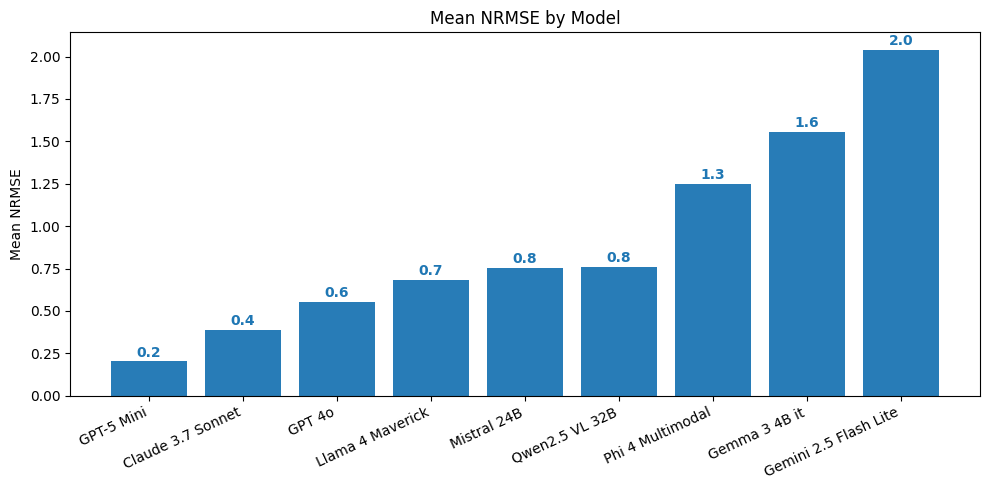

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(
    combined_nrmse["Model"], combined_nrmse["Mean NRMSE"], color="#1f77b4", alpha=0.8
)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Mean NRMSE")
plt.title("Mean NRMSE by Model")
bars = plt.bar(
    combined_nrmse["Model"], combined_nrmse["Mean NRMSE"], color="#1f77b4", alpha=0.8
)
# Annotate each bar with its value in blue
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        color="#1f77b4",
        fontsize=10,
        fontweight="bold",
    )
plt.tight_layout()
plt.savefig("../outputs/thesis/general/mean_nrmse_bar_plot.pdf", bbox_inches="tight")
plt.show()

In [ ]:
cue_combo_line_length = pd.read_csv(
    "../outputs/thesis/line_length_ratio/dataframes/aug_cue_combo.csv"
)
cue_combo_marker_location = pd.read_csv(
    "../outputs/thesis/marker_location/dataframes/aug_cue_combo.csv"
)
cue_combo_maze_distance = pd.read_csv(
    "../outputs/thesis/maze_distance/dataframes/aug_cue_combo.csv"
)

# Example: Add experiment label and concatenate
dfs = [
    cue_combo_line_length.assign(experiment="line_length_ratio"),
    cue_combo_marker_location.assign(experiment="marker_location"),
    cue_combo_maze_distance.assign(experiment="maze_distance"),
]
combined_df = pd.concat(dfs, axis=0, ignore_index=True)
combined_df

,model,scope,k,aic,rmse_to_llm,r2_to_llm,r2_to_truth,rmse_vs_truth,bias_vs_truth,aic_weight,base,LLM_model,w_img,rebased_RMSE,experiment
0,EmpiricalLinear,overall,2.0,-732.004021,0.086005,0.446581,0.109145,0.198729,-1.308701e-01,9.999743e-01,base_4,google_gemini-2.5-flash-lite,0.817190,0.897690,line_length_ratio
1,Combo_NonOracle,overall,0.0,-710.867110,0.093522,0.345616,0.283431,0.178232,-1.081796e-01,2.571385e-05,base_4,google_gemini-2.5-flash-lite,0.624435,0.805104,line_length_ratio
2,Equal,overall,0.0,-675.783135,0.105124,0.173179,0.363607,0.167965,-9.353136e-02,6.191253e-13,base_4,google_gemini-2.5-flash-lite,0.500000,0.758727,line_length_ratio
3,Combo_Oracle,overall,0.0,-522.592391,0.175174,-1.295852,0.560405,0.139599,-6.513308e-17,3.363808e-46,base_4,google_gemini-2.5-flash-lite,0.450996,0.630593,line_length_ratio
4,LLM(Combined),overall,NaN,NaN,0.000000,1.000000,-0.105488,0.221378,-1.521500e-01,NaN,base_4,google_gemini-2.5-flash-lite,NaN,1.000000,line_length_ratio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,EmpiricalLinear,overall,2.0,403.925341,3.792724,-2.310425,-7.508693,5.920574,4.967241e+00,1.000000e+00,base,gemma-3-4b-it,0.956658,0.773470,maze_distance
1211,Equal,overall,0.0,441.960516,4.363182,-3.381150,-2.784550,3.948567,3.445810e+00,5.505119e-09,base,gemma-3-4b-it,0.500000,0.515845,maze_distance
1212,Combo_NonOracle,overall,0.0,500.147068,5.297086,-5.457366,-0.792875,2.717736,2.358940e+00,1.275609e-21,base,gemma-3-4b-it,0.173776,0.355048,maze_distance
1213,Combo_Oracle,overall,0.0,607.436224,7.574501,-12.203508,0.588510,1.302003,-3.647453e-15,6.429444e-45,base,gemma-3-4b-it,-0.008905,0.170095,maze_distance


In [49]:
# Compute mean rebased_RMSE for each LLM_model and model (oracle/non-oracle)
mean_rmse = filtered.groupby(["LLM_model"], as_index=False)["rebased_RMSE"].mean()

# Display the result
mean_rmse.sort_values("rebased_RMSE", ascending=False, inplace=True)

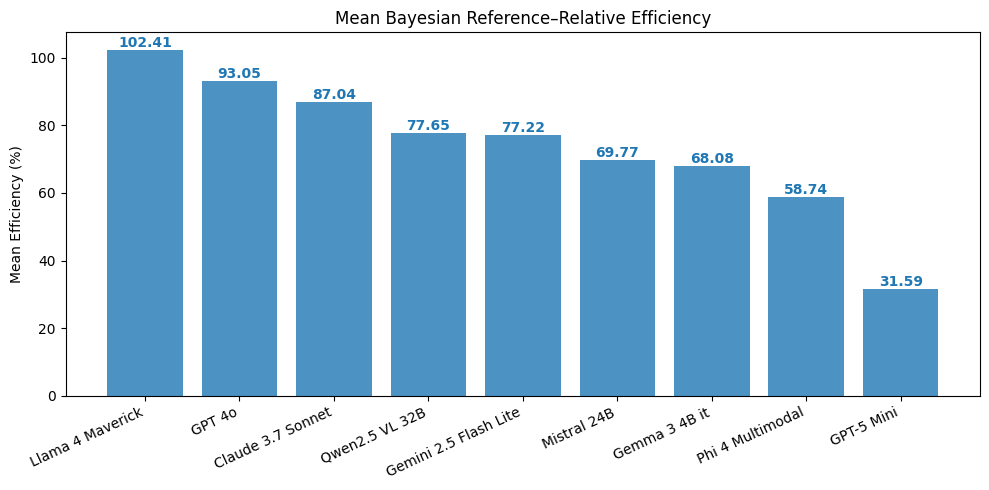

In [ ]:
# Get nice names for x-axis labels
nice_labels = [MODEL_NAME.get(m, m) for m in mean_rmse["LLM_model"]]

# Convert to percentage
percent_values = mean_rmse["rebased_RMSE"] * 100

plt.figure(figsize=(10, 5))
bars = plt.bar(nice_labels, percent_values, color="#1f77b4", alpha=0.8)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Mean Efficiency (%)")
plt.title("Mean Bayesian Reference–Relative Efficiency")
plt.tight_layout()
# bars = plt.bar(nice_labels, mean_rmse["rebased_RMSE"], color="#1f77b4", alpha=0.8)

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        color="#1f77b4",
        fontsize=10,
        fontweight="bold",
    )

plt.savefig(
    "../outputs/thesis/general/mean_Bayesian_efficiency.pdf", bbox_inches="tight"
)
plt.show()